# Search for short-term gainers on the S&P500

The goal is to flag short term gainers relative to the market for possible investment and short term growth. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from yahoo_fin import stock_info as si    # functions to read in ticker time series
from forex_python.converter import CurrencyRates  # functions for currency conversion rates
import datetime as dt
import pickle, os
%matplotlib inline

## Define global parameters and utility functions 

In [2]:
global todays_date
d = dt.datetime.now()
todays_date = dt.datetime(d.year, d.month, d.day)


def CAD2USD(cad):
    c = CurrencyRates()
    return c.get_rate('CAD','USD') * cad


def USD2CAD(usd):
    return usd / CAD2USD(1)


def get_tickers(in_dict):
    '''Get list of tickers from a dictionary. Tickers must begin with capital letters.'''
    tickers = np.array([t if t.isupper() else None for t in in_dict.keys()])
    return tickers[tickers != None]

In [109]:
def plot_timeseries_indiv(dataframe, quantity='frac_growth'):
    plt.figure(figsize=(14,7))
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=5)
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=5)
    
    #gain = dataframe[quantity] > dataframe[quantity][0]
    #loss = dataframe[quantity] <= dataframe[quantity][0]
    #ax1.plot(dataframe.index.map(mdates.date2num), dataframe[quantity], 'b-')
    #ax2.bar(dataframe.index.map(mdates.date2num), dataframe['volume'])
    
    ax1.plot(dataframe.index, dataframe[quantity], 'b-')
    ax2.bar(dataframe.index, dataframe['volume'])
    
    ax1.set_xticklabels('')
    ax1.set_ylabel(quantity, fontsize=12)
    ax1.set_title(dataframe['ticker'][0], fontsize=12)
    
    ax2.set_ylabel('Volume', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    
    
def plot_timeseries_SP500(sp500_dict, ticker_dict={}):
    plt.figure(figsize=(14,7))
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=5)
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=5)
   
    # plot sp500
    ax1.plot(sp500_dict['AAPL'].index, sp500_dict['sp500_frac_growth_mean'], 'b-', label='mean S&P500')
    ax1.plot(sp500_dict['AAPL'].index, sp500_dict['sp500_frac_growth_median'], 'g-', label='median S&P500')
    ax2.bar(sp500_dict['AAPL'].index, sp500_dict['sp500_volume'])
        
    # plot compariosn ticker if given
    if len(ticker_dict) > 0:
        ticker = list(ticker_dict.keys())[0]
        ax1.plot(ticker_dict[ticker].index, ticker_dict[ticker]['frac_growth'], 'k-', label=ticker)
        
    ax1.set_xticklabels('')
    ax1.set_ylabel('S&P 500 fractional growth', fontsize=12)
    
    ax2.set_ylabel('Volume', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    
    ax1.legend(fontsize=12)

## Functions to compute the S&P500 growth

In [98]:
def get_sp500_timeseries(start_date, end_date, retrieve_new_data=False):
    '''Get the time series data of all S&P500 tickers over an input date range.'''

    # save s&p500 ticker data to a dictionary if necessary or updated data is desired
    sp500_ticker_fname = './sp500_ticker_data'
    if not os.path.exists(sp500_ticker_fname) or retrieve_new_data:
        sp500_dict, count = {}, 0
        for t in np.sort(si.tickers_sp500()[1:]):   # skip first entry which is a header

            count += 1
            print('%.3d\t%s'%(count, t))

            try:
                sp500_dict[t] = si.get_data(t, start_date=start_date, end_date=end_date)
            except KeyError:
                pass
                
        # pickle the ticker data
        f = open(sp500_ticker_fname, 'wb')
        pickle.dump(sp500_dict, f)
        f.close()
    
    
    # read-in ticker data if it exists and no override is insisted upon
    else:
        f = open(sp500_ticker_fname, 'rb')
        sp500_dict = pickle.load(f)
        f.close()
        
        # restrict date range if they do not already match
        if (sp500_dict['AAPL'].index[0] < start_date.date()) | (sp500_dict['AAPL'].index[-1] > end_date.date()):
            print('Restricting to the new date range of %s to %s.'%(start_date.isoformat(), end_date.isoformat()))
            for t,df in sp500_dict.items():
                sp500_dict[t] = df.loc[start_date.date() : end_date.date()]
                
            # pickle the ticker data over the new date range
            f = open(sp500_ticker_fname, 'wb')
            pickle.dump(sp500_dict, f)
            f.close()
    
    # return dicitionary of sp500 tickers and their available time series
    return sp500_dict

In [100]:
def compute_fractional_growth(ticker_dict, quantity='adjclose'):
    '''Given a dictionary of ticker keys and time series data values, compute the fractional growth of each ticker
    over time which is set by the doctionary data.'''
    for t, df in ticker_dict.items():
        
        # ensure that this quantity has time series data
        try:
            arr = df[quantity]
        except KeyError:
            raise ValueError('Input time series quantity must one of: "%s".'%('", "'.join(df.columns)))
        
        # compute the fractional growth of this quantity from the initial epoch
        ticker_dict[t]['frac_growth'] = (arr - arr[0]) / arr[0]
        
    # return dictionary of tickers and their time series including their fractional growth
    return ticker_dict

In [101]:
def compute_sp500_fractional_growth(sp500_ticker_dict):
    '''Ad hoc calculation of the fractional growth of the S&P500 index from a dictionary of all sp500 ticker 
    fractional growth time series.'''
    # compile fractional growth time series
    Ntickers = len(sp500_ticker_dict)
    Npnts,_ = sp500_ticker_dict['AAPL'].shape
    sp500_fractional_growth = np.zeros((Npnts,Ntickers))
    sp500_volume = np.zeros((Npnts,Ntickers))
    i = 0 
    for t, df in sp500_ticker_dict.items():
        
        if df['frac_growth'].size == Npnts:
            sp500_fractional_growth[:,i] = df['frac_growth'] 
            sp500_volume[:,i] = df['volume']
            
        else:
            sp500_fractional_growth[:,i] = np.repeat(np.nan,Npnts)
            sp500_volume[:,i] = np.repeat(np.nan,Npnts)

        i += 1
    
    # compute average fractional growth of the sp500
    sp500_ticker_dict['sp500_frac_growth_mean'] = np.nanmean(sp500_fractional_growth, axis=1) 
    sp500_ticker_dict['sp500_frac_growth_median'] = np.nanmedian(sp500_fractional_growth, axis=1) 

    # add sp500 volume
    sp500_dict['sp500_volume'] = np.nansum(sp500_volume, axis=1)
    
    # compute change in time
    tarr = sp500_ticker_dict['AAPL'].index.map(mdates.date2num)
    sp500_ticker_dict['delta_t_days'] = tarr - tarr.min()
    
    return sp500_ticker_dict

## compile all S&P 500 data

In [102]:
# set start and end dates
start_date = dt.datetime(2019,1,1)
end_date = dt.datetime(2019,4,1)

Here we retrieve the market data to compare against our potential stocks of interest.<br>
1. Get the OHLC and volume of all tickers listed on the S&P 500 over the desired date range.<br>
2. Compute each ticker's fractional growth based on some quantity like say, its adjusted daily closing price.<br>
3. Combine the fractional growth of all S&P 500 tickers to get the index performance over time. This is what we will compare the growth of individual stocks to.

In [103]:
sp500_dict = get_sp500_timeseries(start_date, end_date)    # get time series data from the web
sp500_dict = compute_fractional_growth(sp500_dict)         # compute the fractional growth of each ticker
sp500_dict = compute_sp500_fractional_growth(sp500_dict)   # ad hoc calculation of fractional growth of the S&P

Restricting to the new date range of 2019-01-01T00:00:00 to 2019-04-01T00:00:00.


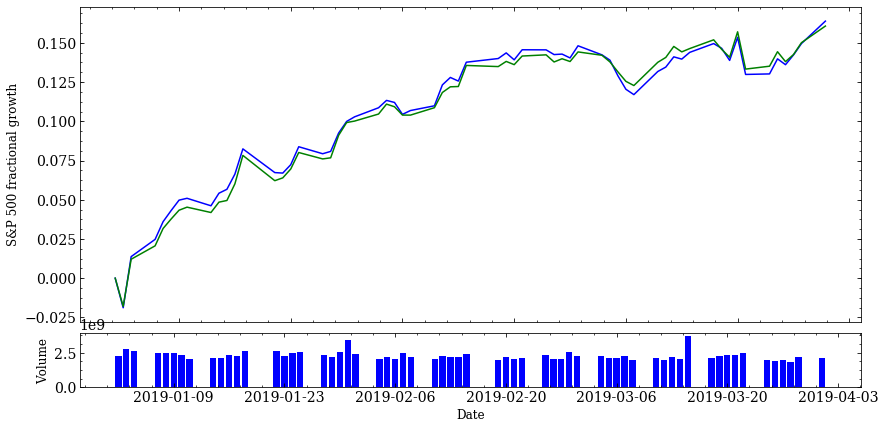

In [104]:
# plot S&P 500
plot_timeseries_SP500(sp500_dict)

## play the game, play the game, play the game, play the game...

In [117]:
ticker = 'HMMJ.TO'
ticker_dict = {ticker: si.get_data(ticker, start_date=start_date, end_date=end_date)}
ticker_dict = compute_fractional_growth(ticker_dict)

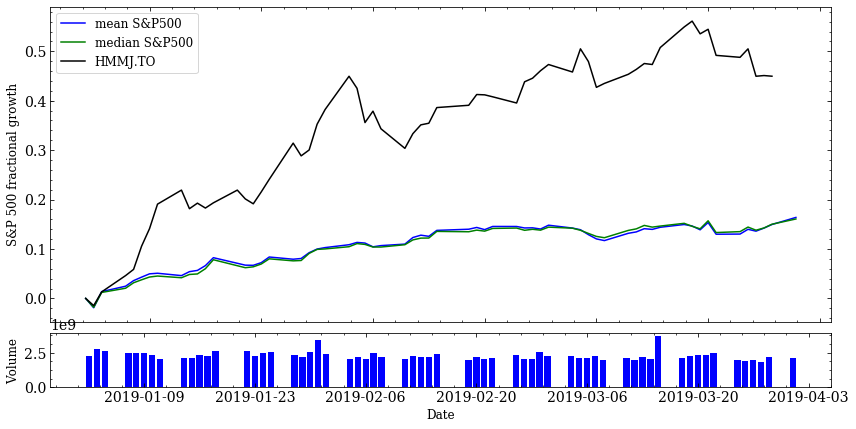

In [118]:
plot_timeseries_SP500(sp500_dict, ticker_dict)